Now I will load the exact same dataset (CIFAR-10) from tensorflow and carry out the same pre-processing steps as I did previously.

Training set shape: (50000, 32, 32, 3) images
Test set shape: (10000, 32, 32, 3) images
Image dimensions: 32x32 pixels


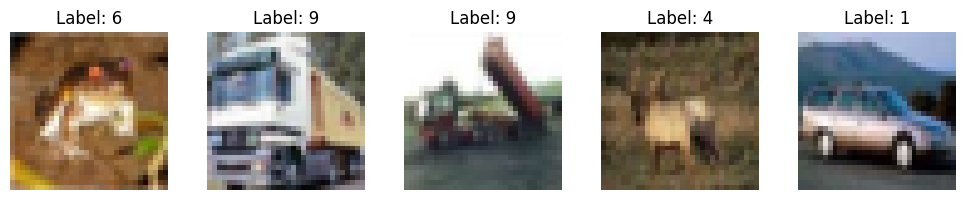

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(f"Training set shape: {x_train.shape} images")
print(f"Test set shape: {x_test.shape} images")
print(f"Image dimensions: {x_train.shape[1]}x{x_train.shape[2]} pixels")

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(x_train[i])
    ax.set_title(f"Label: {y_train[i][0]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [2]:
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, RandomCrop
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image

mean = [0.4914, 0.4822, 0.4465]
std = [0.247, 0.243, 0.261]

train_transform = Compose([
    ToTensor(),
    Normalize(mean, std)
])

test_transform = Compose([
    ToTensor(),
    Normalize(mean, std)
])

x_train_transformed = torch.stack([
    train_transform(Image.fromarray(img)) for img in x_train
])
x_test_transformed = torch.stack([
    test_transform(Image.fromarray(img)) for img in x_test
])

y_train_tensor = torch.tensor(y_train).long()
y_test_tensor = torch.tensor(y_test).long()

In [15]:
from torch.utils.data import DataLoader, TensorDataset

criterion = nn.CrossEntropyLoss()

train_dataset = TensorDataset(x_train_transformed, y_train_tensor)
test_dataset = TensorDataset(x_test_transformed, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"
]

def train_model_epoch(model, optimizer, epochs):
    for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            all_labels = []
            all_predictions = []

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                labels = labels.squeeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

            precision = precision_score(all_labels, all_predictions, average='weighted')
            recall = recall_score(all_labels, all_predictions, average='weighted')
            f1 = f1_score(all_labels, all_predictions, average='weighted')

            print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")
            print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

            if epoch == 9:
                cm = confusion_matrix(all_labels, all_predictions, labels=range(10))

                plt.figure(figsize=(10, 8))
                sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
                plt.xlabel("Predicted Labels")
                plt.ylabel("True Labels")
                plt.title("Confusion Matrix")
                plt.show()

Everything is now set up to expand and test with larger neural networks. I will record the training results after each improvement to monitor convergence and metrics and then carry out a final evaluation on the test set.

The last model had 2 convolutional layers, 1 pooling layer and 2 fully connected layers. I will firstly add a dropout layer.

Epoch [1/10], Loss: 1.6077, Accuracy: 47.06%
Precision: 0.4653, Recall: 0.4706, F1 Score: 0.4659
Epoch [2/10], Loss: 1.0352, Accuracy: 63.76%
Precision: 0.6343, Recall: 0.6376, F1 Score: 0.6356
Epoch [3/10], Loss: 0.8482, Accuracy: 70.14%
Precision: 0.6993, Recall: 0.7014, F1 Score: 0.7002
Epoch [4/10], Loss: 0.6898, Accuracy: 75.95%
Precision: 0.7583, Recall: 0.7595, F1 Score: 0.7588
Epoch [5/10], Loss: 0.5461, Accuracy: 80.93%
Precision: 0.8086, Recall: 0.8093, F1 Score: 0.8089
Epoch [6/10], Loss: 0.4155, Accuracy: 85.31%
Precision: 0.8528, Recall: 0.8531, F1 Score: 0.8529
Epoch [7/10], Loss: 0.3258, Accuracy: 88.57%
Precision: 0.8855, Recall: 0.8857, F1 Score: 0.8856
Epoch [8/10], Loss: 0.2632, Accuracy: 90.69%
Precision: 0.9068, Recall: 0.9069, F1 Score: 0.9069
Epoch [9/10], Loss: 0.2271, Accuracy: 92.10%
Precision: 0.9210, Recall: 0.9210, F1 Score: 0.9210
Epoch [10/10], Loss: 0.2040, Accuracy: 92.97%
Precision: 0.9297, Recall: 0.9297, F1 Score: 0.9297


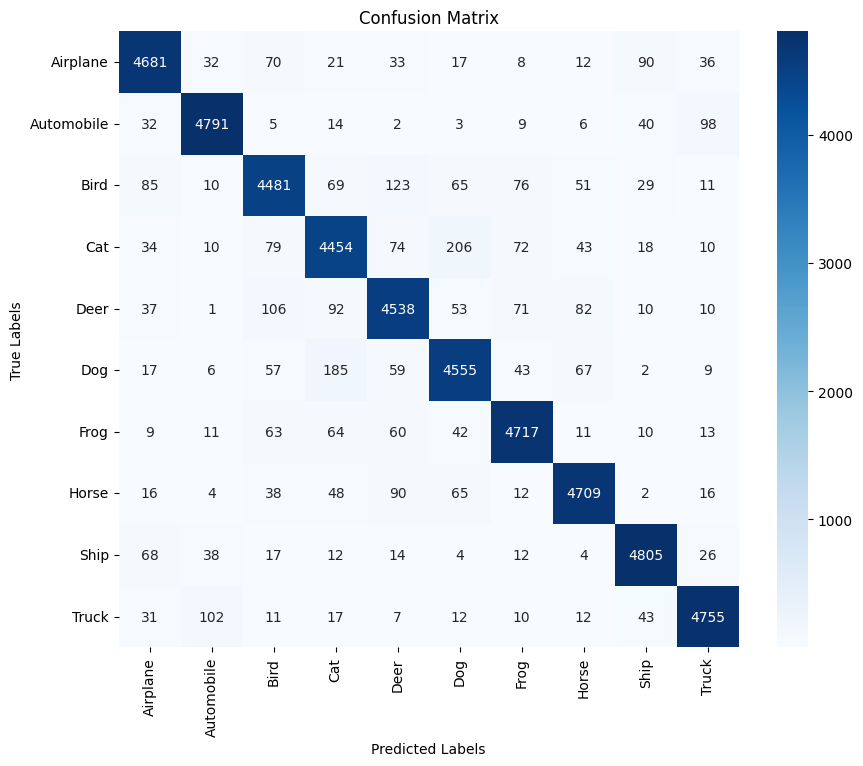

In [34]:
class CNN_Optimized(nn.Module):
    def __init__(self):
        super(CNN_Optimized, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

learning_rate = 0.001
num_epochs = 10

model_optimized = CNN_Optimized()
model_optimized.to(device)

model_optimized_optimizer = torch.optim.RMSprop(
    model_optimized.parameters(), lr=learning_rate, weight_decay=1e-4
)

train_model_epoch(model_optimized, model_optimized_optimizer, num_epochs)


Now I will add 1 Convolutional layer and 1 more Pooling layer:

Epoch [1/10], Loss: 1.5022, Accuracy: 47.62%
Precision: 0.4706, Recall: 0.4762, F1 Score: 0.4716
Epoch [2/10], Loss: 0.9863, Accuracy: 65.56%
Precision: 0.6521, Recall: 0.6556, F1 Score: 0.6535
Epoch [3/10], Loss: 0.7791, Accuracy: 72.86%
Precision: 0.7267, Recall: 0.7286, F1 Score: 0.7275
Epoch [4/10], Loss: 0.6338, Accuracy: 77.89%
Precision: 0.7775, Recall: 0.7789, F1 Score: 0.7781
Epoch [5/10], Loss: 0.5153, Accuracy: 81.95%
Precision: 0.8185, Recall: 0.8195, F1 Score: 0.8189
Epoch [6/10], Loss: 0.4124, Accuracy: 85.37%
Precision: 0.8532, Recall: 0.8537, F1 Score: 0.8534
Epoch [7/10], Loss: 0.3361, Accuracy: 88.06%
Precision: 0.8802, Recall: 0.8806, F1 Score: 0.8804
Epoch [8/10], Loss: 0.2729, Accuracy: 90.45%
Precision: 0.9044, Recall: 0.9045, F1 Score: 0.9045
Epoch [9/10], Loss: 0.2349, Accuracy: 91.86%
Precision: 0.9185, Recall: 0.9186, F1 Score: 0.9185
Epoch [10/10], Loss: 0.2081, Accuracy: 92.77%
Precision: 0.9276, Recall: 0.9277, F1 Score: 0.9276


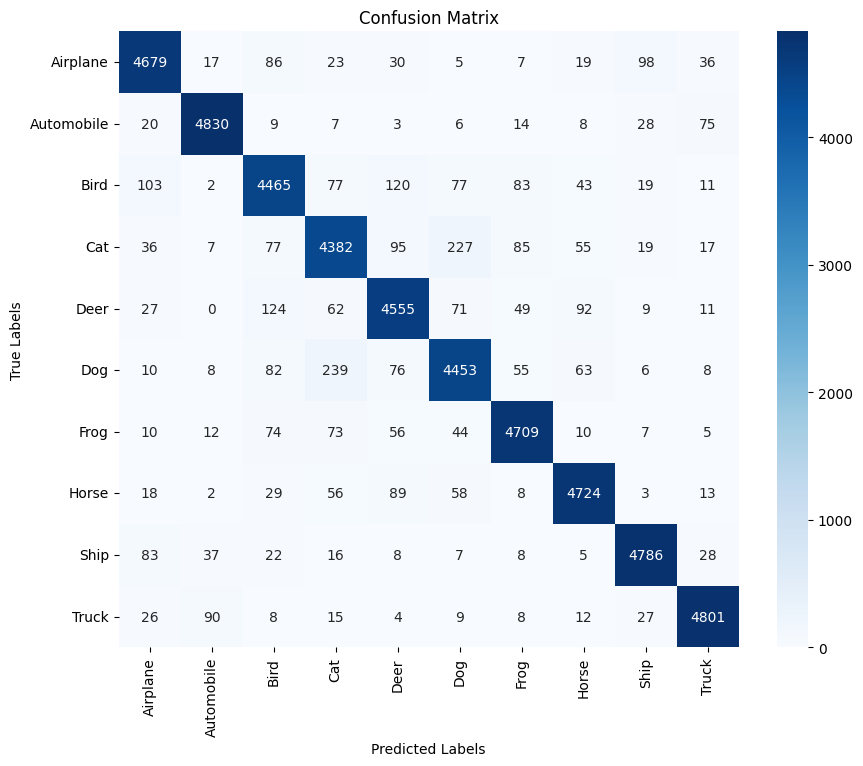

In [35]:
class CNN_Optimized(nn.Module):
    def __init__(self):
        super(CNN_Optimized, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model_optimized_2 = CNN_Optimized()
model_optimized_2.to(device)

model_optimized_optimizer_2 = torch.optim.RMSprop(
    model_optimized_2.parameters(), lr=learning_rate, weight_decay=1e-4
)

train_model_epoch(model_optimized_2, model_optimized_optimizer_2, num_epochs)


Now 1 more convolutional layer and 1 more fully connected layer:

Epoch [1/10], Loss: 1.8723, Accuracy: 41.80%
Precision: 0.4109, Recall: 0.4180, F1 Score: 0.4126
Epoch [2/10], Loss: 1.1042, Accuracy: 60.53%
Precision: 0.6021, Recall: 0.6053, F1 Score: 0.6035
Epoch [3/10], Loss: 0.8515, Accuracy: 70.23%
Precision: 0.7006, Recall: 0.7023, F1 Score: 0.7014
Epoch [4/10], Loss: 0.6988, Accuracy: 75.50%
Precision: 0.7540, Recall: 0.7550, F1 Score: 0.7544
Epoch [5/10], Loss: 0.5914, Accuracy: 79.52%
Precision: 0.7944, Recall: 0.7952, F1 Score: 0.7947
Epoch [6/10], Loss: 0.4975, Accuracy: 82.62%
Precision: 0.8258, Recall: 0.8262, F1 Score: 0.8259
Epoch [7/10], Loss: 0.4168, Accuracy: 85.46%
Precision: 0.8542, Recall: 0.8546, F1 Score: 0.8543
Epoch [8/10], Loss: 0.3511, Accuracy: 87.68%
Precision: 0.8768, Recall: 0.8768, F1 Score: 0.8767
Epoch [9/10], Loss: 0.2984, Accuracy: 89.63%
Precision: 0.8962, Recall: 0.8963, F1 Score: 0.8962
Epoch [10/10], Loss: 0.2665, Accuracy: 90.66%
Precision: 0.9065, Recall: 0.9066, F1 Score: 0.9065


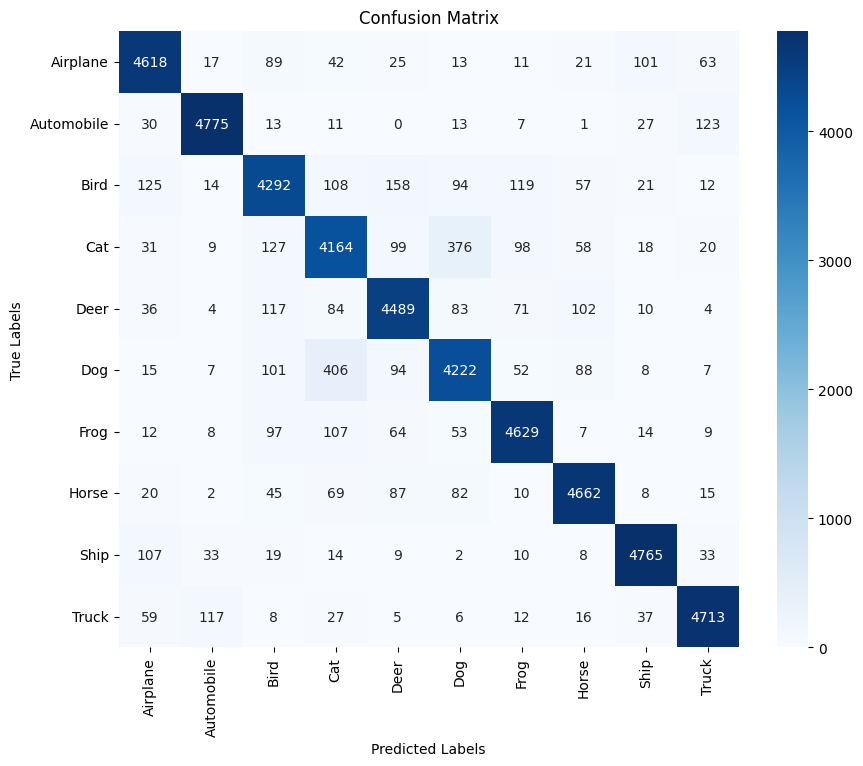

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_Optimized(nn.Module):
    def __init__(self):
        super(CNN_Optimized, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_optimized_3 = CNN_Optimized()
model_optimized_3.to(device)

model_optimized_optimizer_3 = torch.optim.RMSprop(
    model_optimized_3.parameters(), lr=learning_rate, weight_decay=1e-4
)

train_model_epoch(model_optimized_3, model_optimized_optimizer_3, num_epochs)


And 1 more convolutional layer with 1 pooling layer:

Epoch [1/10], Loss: 2.3474, Accuracy: 33.54%
Precision: 0.3332, Recall: 0.3354, F1 Score: 0.3269
Epoch [2/10], Loss: 1.2889, Accuracy: 53.49%
Precision: 0.5289, Recall: 0.5349, F1 Score: 0.5311
Epoch [3/10], Loss: 0.9694, Accuracy: 66.12%
Precision: 0.6589, Recall: 0.6612, F1 Score: 0.6599
Epoch [4/10], Loss: 0.7623, Accuracy: 73.73%
Precision: 0.7360, Recall: 0.7373, F1 Score: 0.7365
Epoch [5/10], Loss: 0.6297, Accuracy: 78.22%
Precision: 0.7815, Recall: 0.7822, F1 Score: 0.7817
Epoch [6/10], Loss: 0.5293, Accuracy: 81.62%
Precision: 0.8157, Recall: 0.8162, F1 Score: 0.8159
Epoch [7/10], Loss: 0.4523, Accuracy: 84.32%
Precision: 0.8429, Recall: 0.8432, F1 Score: 0.8429
Epoch [8/10], Loss: 0.3846, Accuracy: 86.55%
Precision: 0.8654, Recall: 0.8655, F1 Score: 0.8654
Epoch [9/10], Loss: 0.3318, Accuracy: 88.52%
Precision: 0.8850, Recall: 0.8852, F1 Score: 0.8850
Epoch [10/10], Loss: 0.2888, Accuracy: 89.99%
Precision: 0.8998, Recall: 0.8999, F1 Score: 0.8998


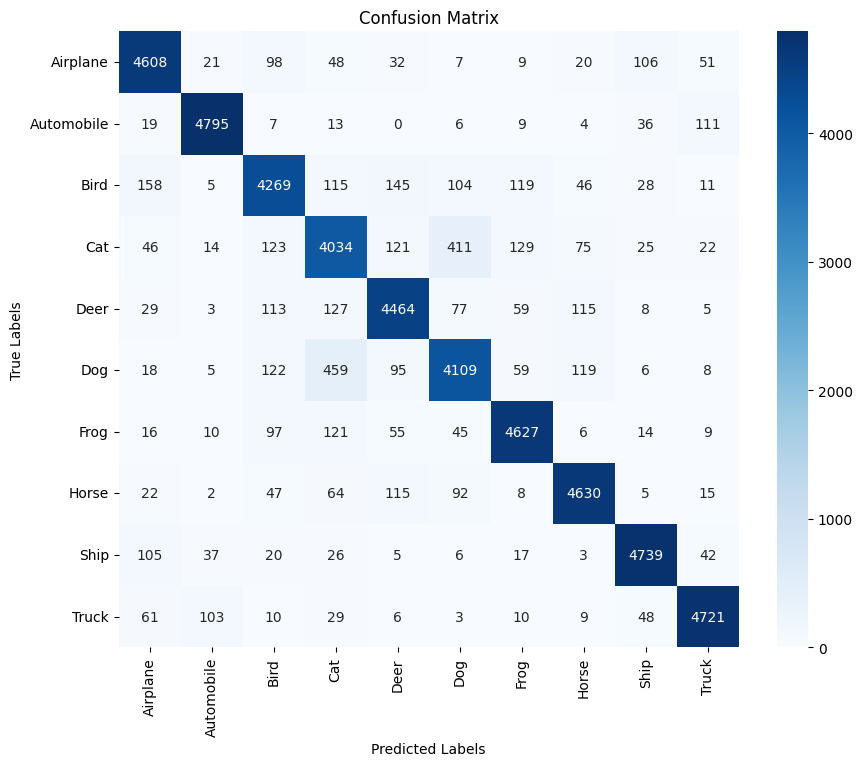

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_Optimized(nn.Module):
    def __init__(self):
        super(CNN_Optimized, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(512 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = F.relu(self.conv5(x))
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_optimized_4 = CNN_Optimized()
model_optimized_4.to(device)

model_optimized_optimizer_4 = torch.optim.RMSprop(
    model_optimized_4.parameters(), lr=learning_rate, weight_decay=1e-4
)

train_model_epoch(model_optimized_4, model_optimized_optimizer_4, num_epochs)

And finally just 1 more fully connected layer and convolutional layer:

Epoch [1/10], Loss: 8.1692, Accuracy: 28.31%
Precision: 0.2822, Recall: 0.2831, F1 Score: 0.2729
Epoch [2/10], Loss: 1.4607, Accuracy: 47.22%
Precision: 0.4647, Recall: 0.4722, F1 Score: 0.4669
Epoch [3/10], Loss: 1.1599, Accuracy: 58.98%
Precision: 0.5842, Recall: 0.5898, F1 Score: 0.5862
Epoch [4/10], Loss: 0.9393, Accuracy: 67.49%
Precision: 0.6725, Recall: 0.6749, F1 Score: 0.6735
Epoch [5/10], Loss: 0.7750, Accuracy: 73.51%
Precision: 0.7343, Recall: 0.7351, F1 Score: 0.7344
Epoch [6/10], Loss: 0.6558, Accuracy: 77.62%
Precision: 0.7756, Recall: 0.7762, F1 Score: 0.7757
Epoch [7/10], Loss: 0.5613, Accuracy: 81.11%
Precision: 0.8105, Recall: 0.8111, F1 Score: 0.8106
Epoch [8/10], Loss: 0.4819, Accuracy: 83.61%
Precision: 0.8358, Recall: 0.8361, F1 Score: 0.8358
Epoch [9/10], Loss: 0.4213, Accuracy: 85.69%
Precision: 0.8566, Recall: 0.8569, F1 Score: 0.8567
Epoch [10/10], Loss: 0.3685, Accuracy: 87.49%
Precision: 0.8746, Recall: 0.8749, F1 Score: 0.8747


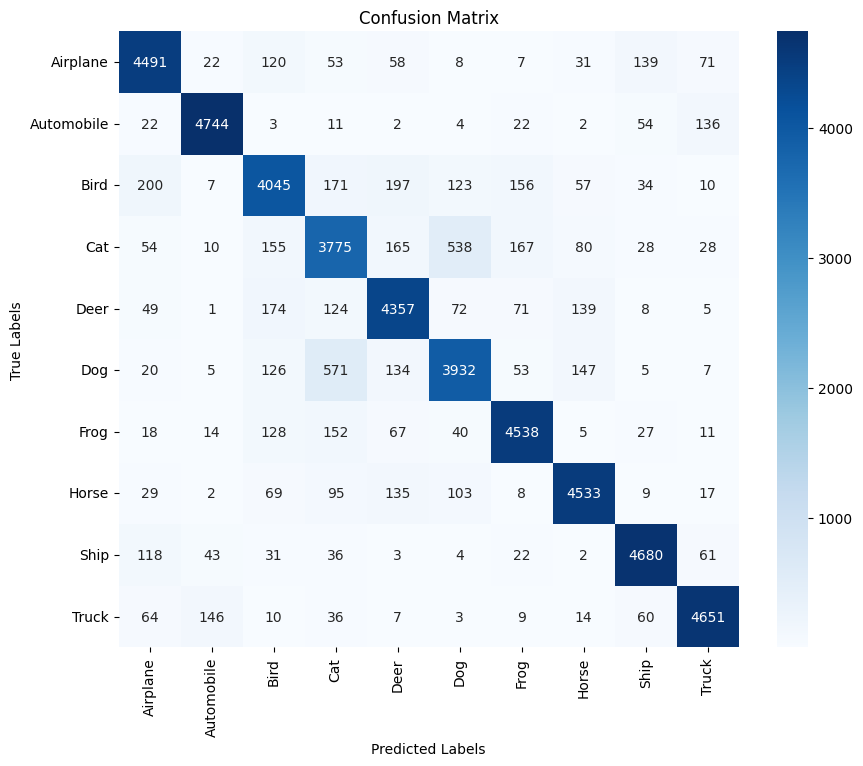

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_Optimized(nn.Module):
    def __init__(self):
        super(CNN_Optimized, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(1024 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model_optimized_5 = CNN_Optimized()
model_optimized_5.to(device)

model_optimized_optimizer_5 = torch.optim.RMSprop(
    model_optimized_5.parameters(), lr=learning_rate, weight_decay=1e-4
)

train_model_epoch(model_optimized_5, model_optimized_optimizer_5, num_epochs)

Test Loss: 0.6384, Accuracy: 79.96%
Precision: 0.8028, Recall: 0.7996, F1 Score: 0.7991


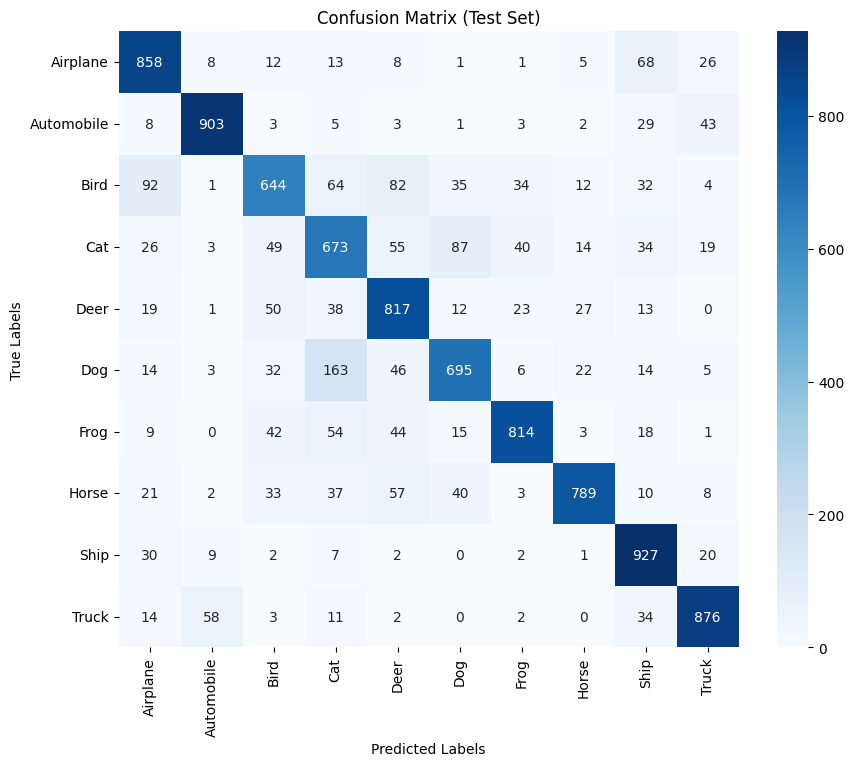

In [53]:
model_optimized_5.eval()
running_loss = 0.0
correct = 0
total = 0

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.squeeze(1)
        outputs = model_optimized_5(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f"Test Loss: {running_loss/len(test_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

cm = confusion_matrix(all_labels, all_predictions, labels=range(10))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Test Set)")
plt.show()